# Initial EDA of the Dominion Power Hourly MegaWatt Usage

---

## Import Key Modules

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


In [30]:
# Using specific styles 
plt.style.use("fivethirtyeight")
color_palette = sns.color_palette() #seaborn color palette

----
## Perform `Data Ingestion`

Here, I am simply reading the data from the csv file into a dataframe and setting the first column in the csv, `Datetime` to be the index value.

In [31]:
data_file_path = "/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/data/DOm_hourly.csv"

In [32]:
raw_df = pd.read_csv(data_file_path)
df = raw_df.set_index("Datetime")
df.index = pd.to_datetime(df.index) #convert index from string to datatime type

---

# Data Analysis

In [33]:
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116189 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DOM_MW  116189 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [35]:
# check for nulls
df.isnull().sum() # result is that there are no null values 

DOM_MW    0
dtype: int64

In [36]:
# Let's get some stats
df.describe() 

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


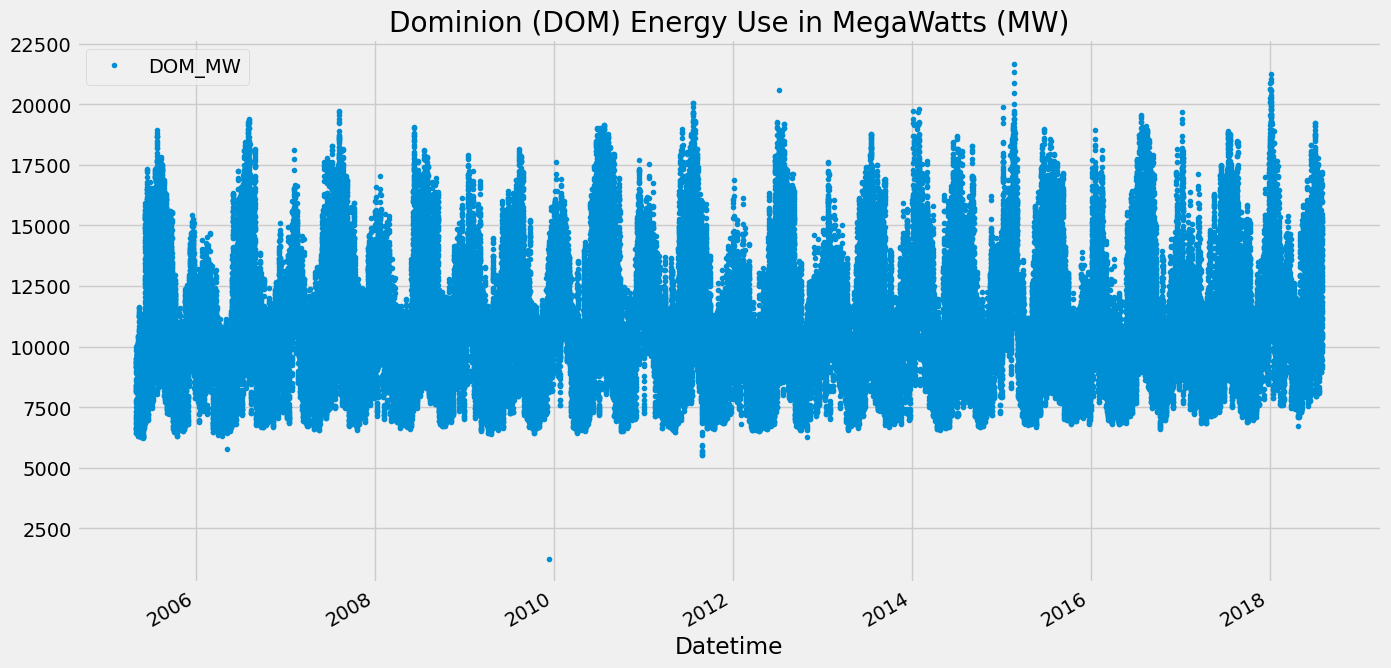

In [37]:
# Initial Visualization of the Raw Dataframe
color_palette = sns.color_palette()

df.plot(
    style = ".",
    figsize = (15, 8),
    color = color_palette[0],
    title = "Dominion (DOM) Energy Use in MegaWatts (MW)"
)
plt.show()

---

# Set-up Training Data for Learning Model

In [38]:
# Using first 10 years ~ 80 of the data for training
train = df.loc[df.index < "2015-01-01"]

# Using Last 3 years ~ 20 of the data for training
test = df.loc[df.index >= "2015-01-01"]

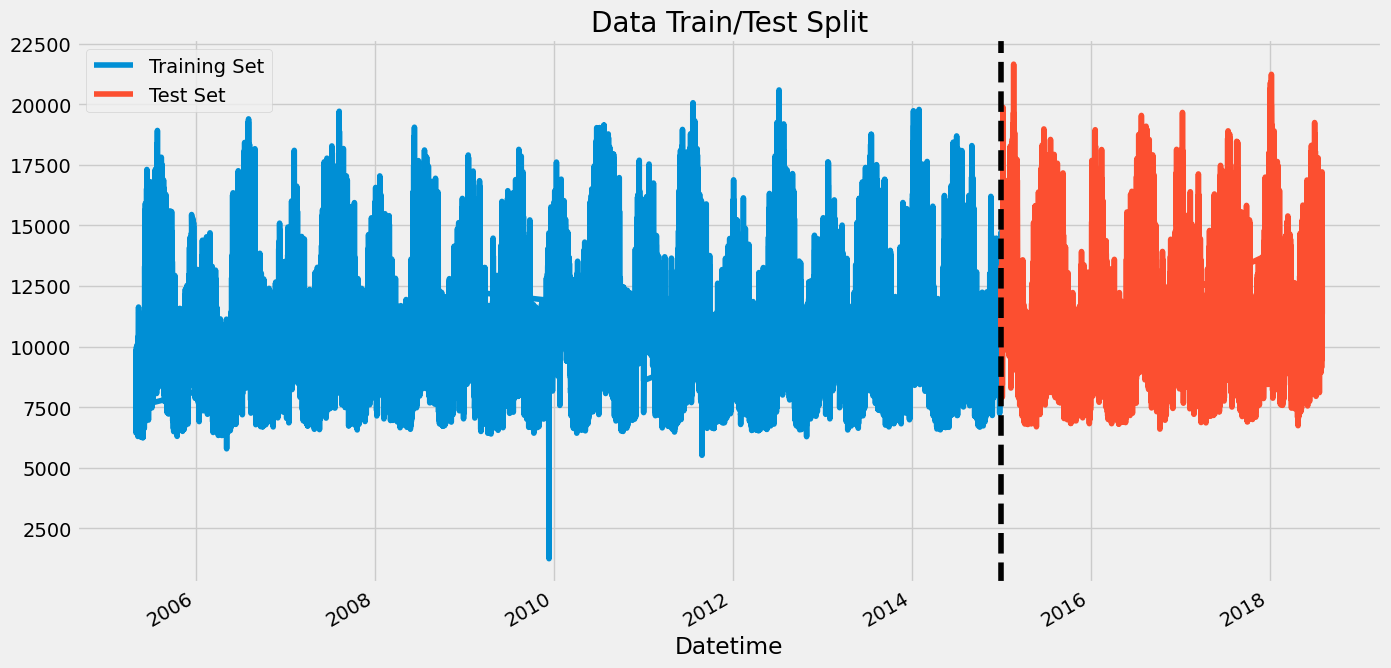

In [39]:
# Visualize Training and Test Data
fig, ax = plt.subplots(figsize = (15, 8))

train.plot(ax = ax, label = "Training Set", title = "Data Train/Test Split")
test.plot(ax = ax, label = "Test set")

ax.axvline("2015-01-01", color = "black", ls = '--')
ax.legend(["Training Set", "Test Set"])

plt.show()

### Look at the Seasonality of A Week's Worth of Data

Here, I am looking at one weeks of data to see the Seasonality use Date Format: `YYY-MM-DD`
* Friday: 2010-01-01
* Friday: 2010-01-08

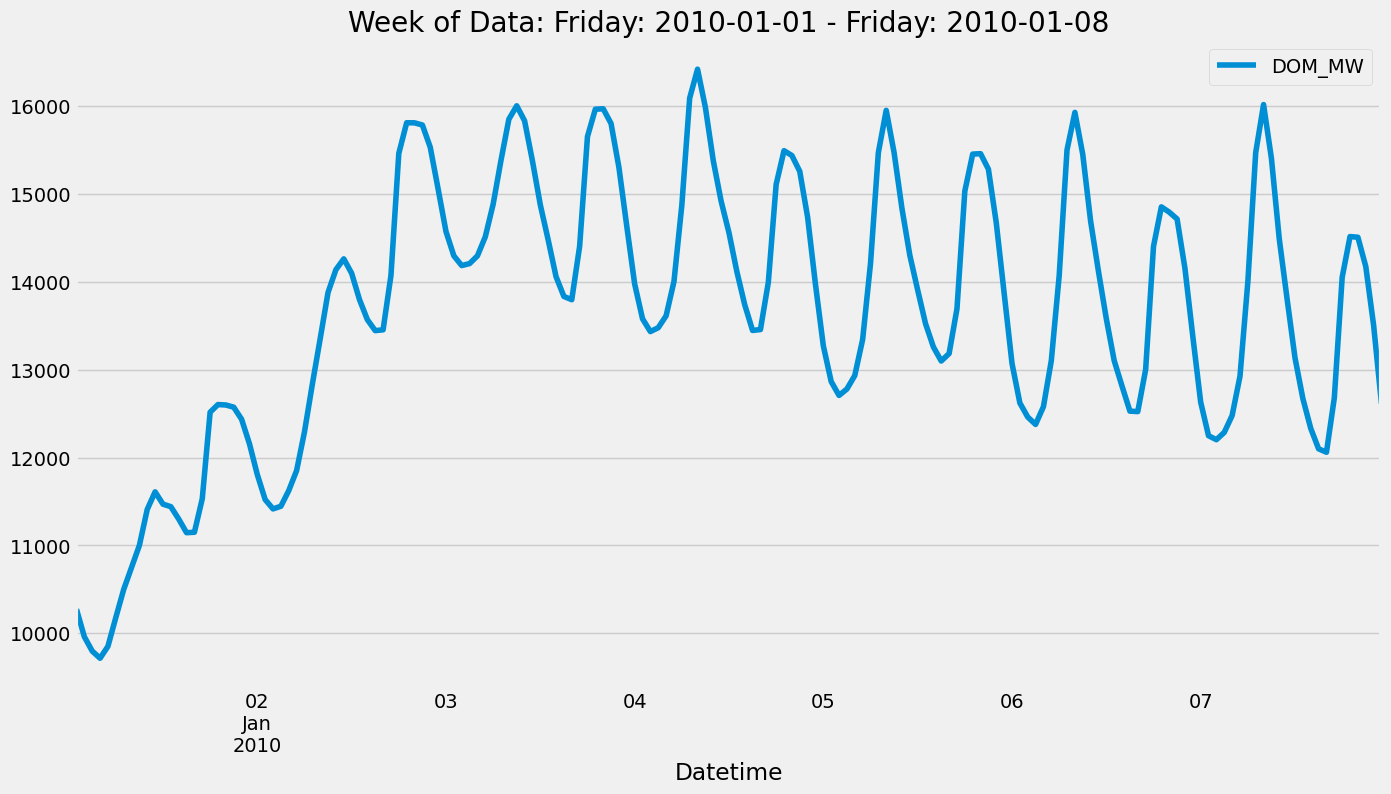

In [40]:
df_week = df.loc[(df.index > "2010-01-01") & (df.index < "2010-01-08")]
df_week = df_week.sort_values(by="Datetime") # wee need to sort to make sure we don't have overlaps in the data
df_week.plot(figsize=(15,8), title="Week of Data: Friday: 2010-01-01 - Friday: 2010-01-08")
plt.show()

## Create Features

In [41]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
  """
  Create time series features based on time series index.
  """
  df = df.copy() #Make deep copy so changes will be done to the copy
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek #in pandas Monday = 0 and Sunday = 6
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

df = create_features(df)

In [42]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Visualize our Feature / Target Relationships

/var/folders/10/l97qc6mn0md1lz6bm0j3x1fh0000gn/T/ipykernel_2281/3583377397.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="hour", y="DOM_MW", palette="tab10")


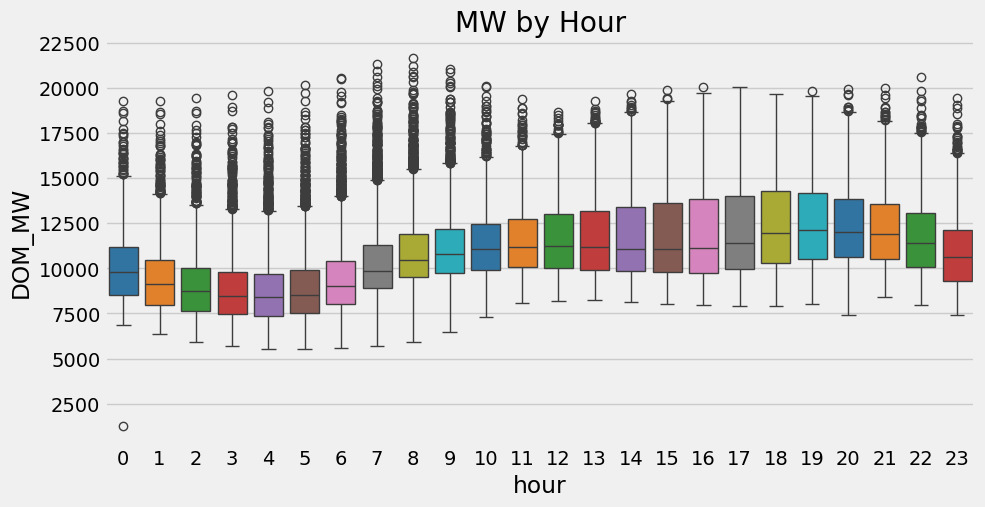

In [43]:
#MW by Hour
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="hour", y="DOM_MW", palette="tab10")
ax.set_title('MW by Hour')
plt.show()

/var/folders/10/l97qc6mn0md1lz6bm0j3x1fh0000gn/T/ipykernel_2281/2485077096.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="dayofweek", y="DOM_MW", palette="tab10")


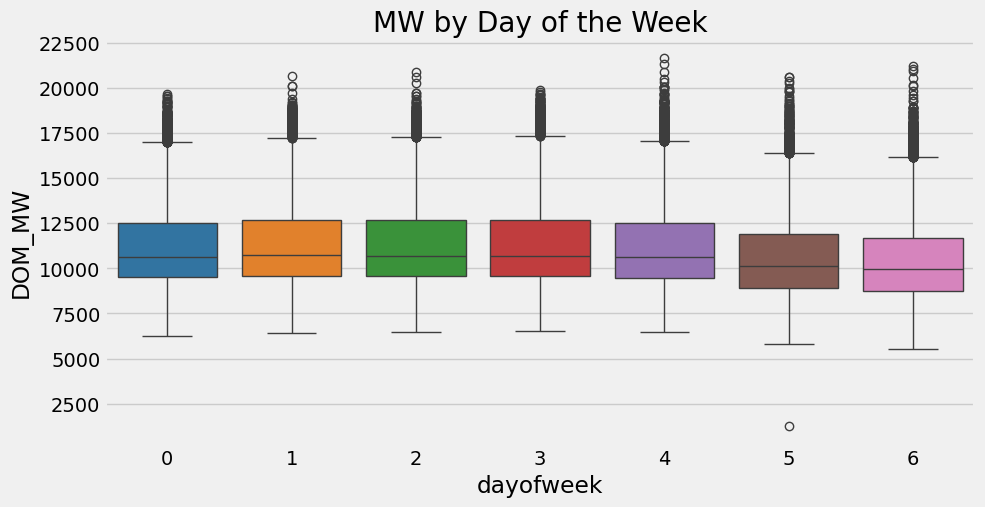

In [44]:
#MW by Day of Week
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="dayofweek", y="DOM_MW", palette="tab10")
ax.set_title("MW by Day of the Week")
plt.show()

/var/folders/10/l97qc6mn0md1lz6bm0j3x1fh0000gn/T/ipykernel_2281/1529065308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="month", y="DOM_MW", palette="tab10")


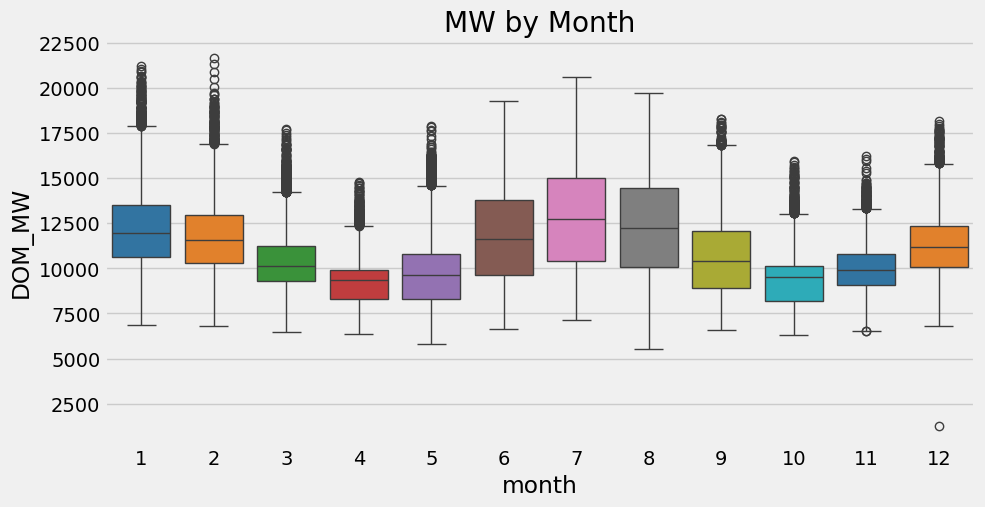

In [45]:
#MW by Month
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="month", y="DOM_MW", palette="tab10")
ax.set_title("MW by Month")
plt.show()

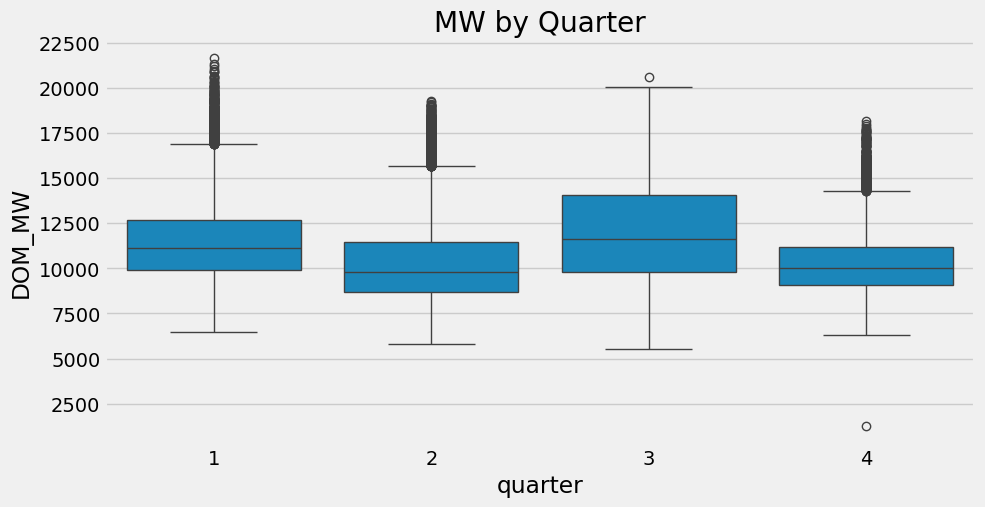

In [46]:
#MW by Quarter
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="quarter", y="DOM_MW")
ax.set_title("MW by Quarter")
plt.show()

/var/folders/10/l97qc6mn0md1lz6bm0j3x1fh0000gn/T/ipykernel_2281/2104573451.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="year", y="DOM_MW", palette="tab10")


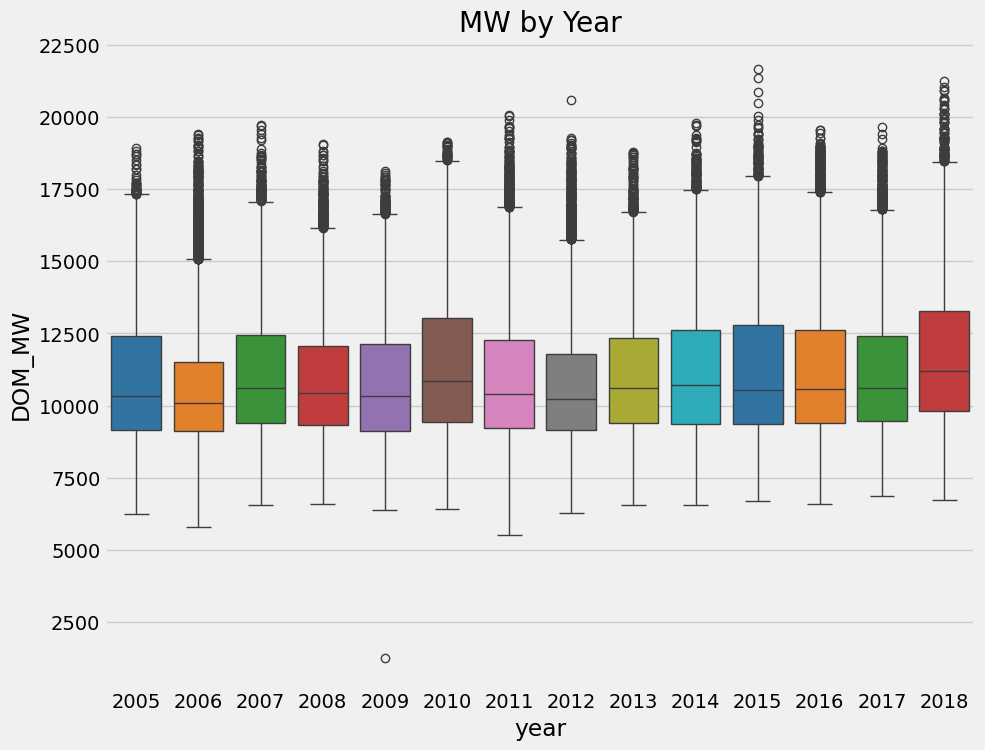

In [47]:
#MW by Year
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="year", y="DOM_MW", palette="tab10")
ax.set_title("MW by Year")
plt.show()

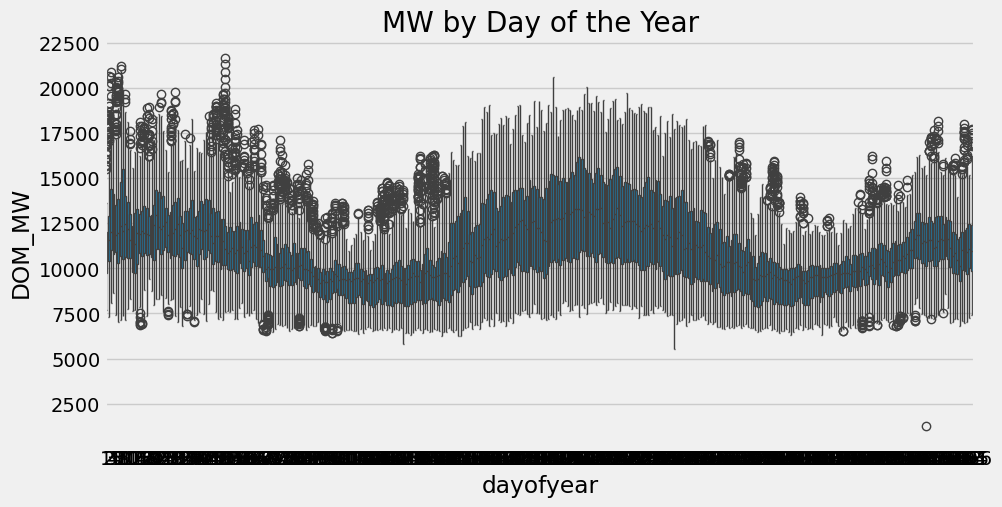

In [48]:
#MW by Day of the Year
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="dayofyear", y="DOM_MW")
ax.set_title("MW by Day of the Year")
plt.show()

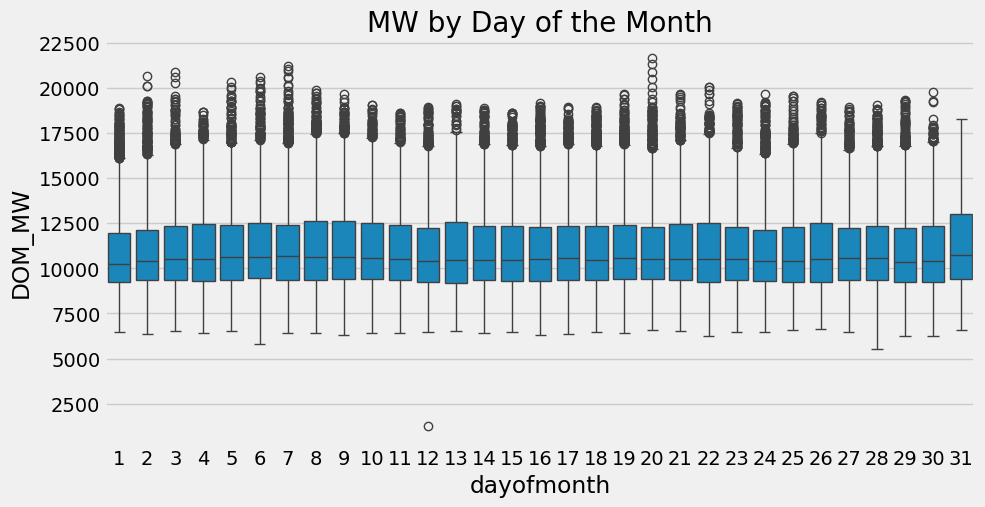

In [49]:
#MW by Day of the Month
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="dayofmonth", y="DOM_MW")
ax.set_title("MW by Day of the Month")
plt.show()

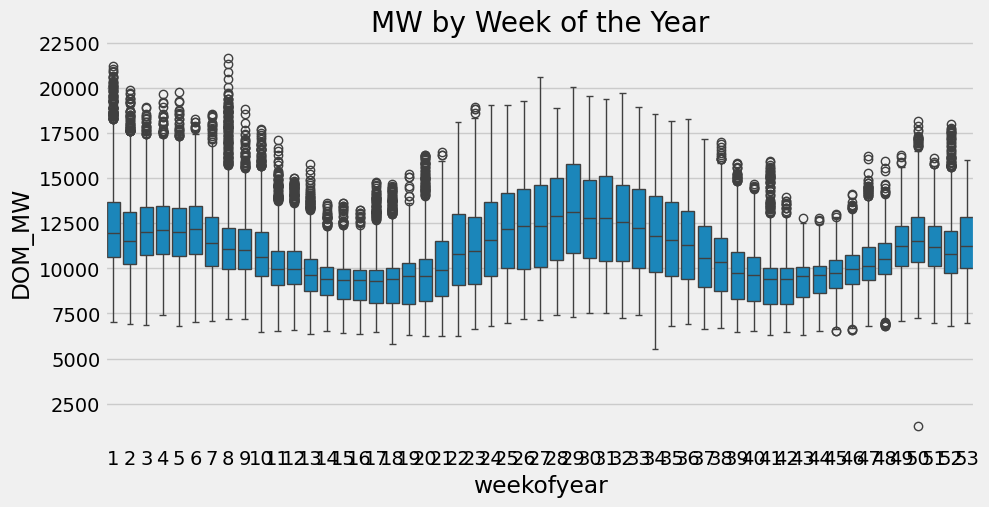

In [50]:
#MW by Week of the Year
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x="weekofyear", y="DOM_MW")
ax.set_title("MW by Week of the Year")
plt.show()

----

# Creating the XGBoost Model



In [51]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'DOM_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [52]:
#train.head()
X_train

,dayofyear,hour,dayofweek,quarter,month,year
Datetime,,,,,,
2005-12-31 01:00:00,365,1,5,4,12,2005
2005-12-31 02:00:00,365,2,5,4,12,2005
2005-12-31 03:00:00,365,3,5,4,12,2005
2005-12-31 04:00:00,365,4,5,4,12,2005
2005-12-31 05:00:00,365,5,5,4,12,2005
...,...,...,...,...,...,...
2014-01-01 20:00:00,1,20,2,1,1,2014
2014-01-01 21:00:00,1,21,2,1,1,2014
2014-01-01 22:00:00,1,22,2,1,1,2014


In [53]:
test.head()

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,12792.0,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,7954.0,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,7605.0,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,7434.0,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,7385.0,4,3,4,12,2015,365,31,53


In [54]:
#Making 
# - n_estimators is the number of trees we will create 
# "reg:linear" - says we are using a linear regression model for XGB
# max_depth is the depth of each tree
#early_stopping = 50 means stop early at 50 trees if we see overfitting
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective="reg:linear",
        max_depth=3,
        learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:10997.64358	validation_1-rmse:11383.53617
[100]	validation_0-rmse:4303.32442	validation_1-rmse:4701.71855


/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [13:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2099.07702	validation_1-rmse:2494.64754
[300]	validation_0-rmse:1515.97425	validation_1-rmse:1882.76756
[400]	validation_0-rmse:1377.85966	validation_1-rmse:1715.87057
[500]	validation_0-rmse:1330.32593	validation_1-rmse:1668.36353
[600]	validation_0-rmse:1304.75434	validation_1-rmse:1647.84652
[700]	validation_0-rmse:1285.13447	validation_1-rmse:1641.27851
[800]	validation_0-rmse:1269.83943	validation_1-rmse:1635.54301
[900]	validation_0-rmse:1256.39392	validation_1-rmse:1631.54833
[999]	validation_0-rmse:1243.62868	validation_1-rmse:1627.85707


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [55]:
reg.feature_names_in_

array(['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year'],
      dtype='<U9')

##  Identifying Feature Importance

`Importance` provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

Here for this data, the model has relied heavily on `Month`, `hour`, and `day of year`, but there are overlaps in the category like day of week will have days that over lap with day of year, so this feature importance is really just tell us collectives (i.e., day of year). We look feature importance to give us an idea of what the model is using. 


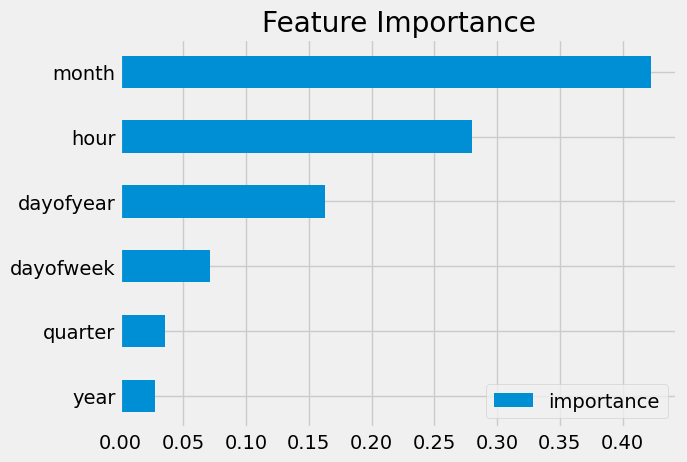

In [56]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecasting Using the Test Data


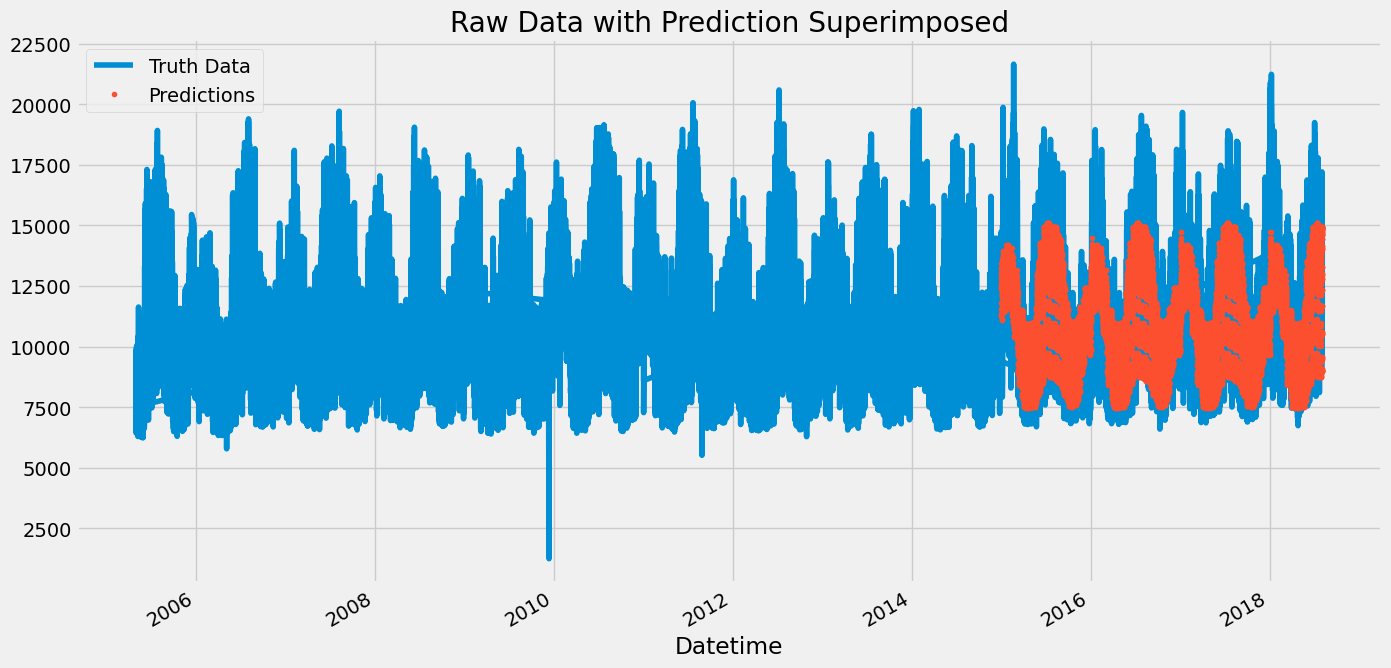

In [57]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[["DOM_MW"]].plot(figsize=(15, 8))
df['prediction'].plot(ax=ax, style='.')
plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data with Prediction Superimposed")
plt.show()

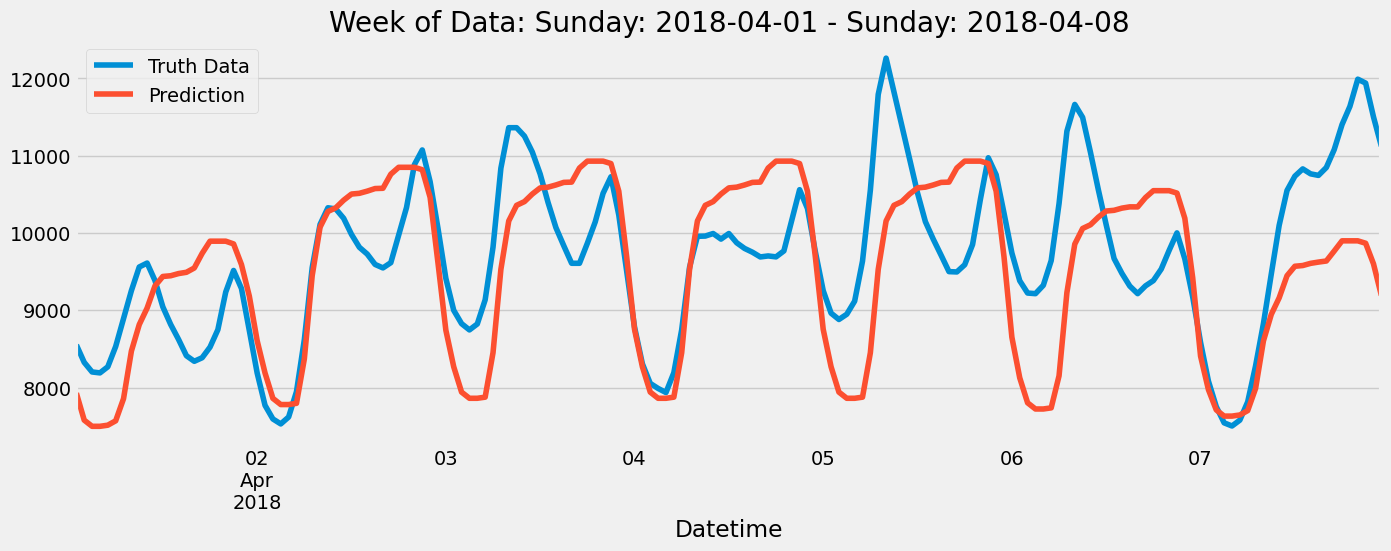

In [58]:
df_week_test = df.loc[(df.index > "2018-04-01") & (df.index < "2018-04-08")]
df_week_test = df_week_test.sort_values(by="Datetime") # wee need to sort to make sure we don't have overlaps in the data

ax = df_week_test["DOM_MW"].plot(figsize=(15, 5), title="Week of Data: Sunday: 2018-04-01 - Sunday: 2018-04-08")
df_week_test["prediction"].plot(style='-')
plt.legend(["Truth Data","Prediction"])
plt.show()

Notice That the model above does an `okay` job of prediction. We could do better by doing more parameter tuning and start to look at adding features for specific days of the year like holidays that might affect enery use.

The predictions do follow the general trend of the real data though!

## Evaluate Using RMSE


In [59]:
## Evaluate Using RMSE

score = np.sqrt(mean_squared_error(test["DOM_MW"], test["prediction"]))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1627.86


In [60]:
## Evaluate Using MAE

score = mean_absolute_error(test["DOM_MW"], test["prediction"])
print(f'MAE Score on Test set: {score:0.2f}')

MAE Score on Test set: 1210.92


# Caclulating the Error

View the worst and best predicted days 

- this data would help identify specific days that we could examin to improve the model

In [61]:
# Getting the worst performing days
test["error"] = np.abs(test[TARGET] - test["prediction"]) # for each hour
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=False).head(10) #Group by the day to find mean of the 24 hour period

date
2015-02-20    6886.717448
2018-01-07    6787.231893
2018-01-06    6711.750488
2018-01-05    5747.796997
2015-02-21    5727.378621
2015-02-16    5454.352783
2018-01-02    5356.351644
2015-02-19    5348.445272
2017-12-31    5272.189087
2018-01-01    5040.308105
Name: error, dtype: float64

In [62]:
# Getting the best performing days
test["error"] = np.abs(test[TARGET] - test["prediction"]) # for each hour
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=True).head(10) #

date
2017-05-05    126.535828
2017-10-14    143.302572
2016-09-27    155.621908
2016-05-13    172.838684
2017-10-24    211.499207
2017-05-22    232.673665
2017-10-29    233.220744
2016-10-04    236.217916
2016-09-25    242.353231
2015-10-03    249.061991
Name: error, dtype: float64